In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
import Levenshtein as lev
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

**Leyendo la base final:**

In [2]:
base_final = pd.read_csv('basefinalfeaturesclean.csv', encoding = 'ISO-8859-1', low_memory = False)

**OHE (One Hot Encoding):**

Para realizar el análisis multivariante, vamos a aplicar un OHE (One-Hot Encoding) que incluya únicamente variables como entidad y sector, ya que tienen una dimensionalidad manejable. Por ahora, no aplicaremos OHE a variables como nombre_act, tipo_vial y tipo_asent, debido a que aumentan significativamente la dimensionalidad. A estas variables les aplicaremos OHE y las incluiremos únicamente para los modelos, no para la matriz de correlación.

In [3]:
columnas_ohe = ['entidad', 'sector']

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output = False, dtype = int)

# Ajustar y transformar los datos
ohe_encoded = ohe.fit_transform(base_final[columnas_ohe])

# Convertir el resultado a un DataFrame
ohe_encoded_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(columnas_ohe))

# Concatenar el DataFrame original con el DataFrame codificado
base_final = pd.concat([base_final.drop(columns=columnas_ohe).reset_index(drop=True), ohe_encoded_df.reset_index(drop=True)], axis=1)

print(base_final)

             id                                          nom_estab  \
0       7702819               2 CONEXION DE SERVICIOS INFORMATICOS   
1       6282298           2227 ORGANIZACION SAHUAYO AGUASCALIENTES   
2       6281310                          2251_AGUASCALIENTES NORTE   
3       6281199                     2252_ AGUASCALIENTES SIGLO XXI   
4       6281969                                2273 AGUASCALIENTES   
...         ...                                                ...   
587294  4643641                 LABORATORIO DE MATERIALES IRACAMPO   
587295  4632102  OFICINA DEL ABOGADO GENERAL DE LA UNIVERSIDAD ...   
587296  4608870               PROYECTO ARQUEOLÓGICO CERRO DEL TEUL   
587297  4631875                                       SIMPLEGRAPHY   
587298  4595881                            SOLAR ENERGIA RENOVABLE   

        codigo_act                                         nombre_act  \
0           434225  Comercio al por mayor de equipo y material ele...   
1           4

In [4]:
base_final.shape

(587299, 58)

**Label Encoding:**

In [5]:
#vars con label encoding: per_ocu, fecha_alta, continuacion_cierre y tipo_persona
le_per_ocu = LabelEncoder()
le_fecha_alta = LabelEncoder()
le_continuacion_cierre = LabelEncoder()
le_tipo_persona = LabelEncoder()

In [6]:
base_final['per_ocu'] = le_per_ocu.fit_transform(base_final['per_ocu'].values)
base_final['fecha_alta'] = le_fecha_alta.fit_transform(base_final['fecha_alta'].values)
base_final['continuacion_cierre'] = le_continuacion_cierre.fit_transform(base_final['continuacion_cierre'].values)
base_final['tipo_persona'] = le_tipo_persona.fit_transform(base_final['tipo_persona'].values)

In [7]:
print("per_ocu:", dict(zip(le_per_ocu.classes_, le_per_ocu.transform(le_per_ocu.classes_))))
print("fecha_alta:", dict(zip(le_fecha_alta.classes_, le_fecha_alta.transform(le_fecha_alta.classes_))))
print("Continuacion_Cierre:", dict(zip(le_continuacion_cierre.classes_, le_continuacion_cierre.transform(le_continuacion_cierre.classes_))))
print("Tipo_Persona:", dict(zip(le_tipo_persona.classes_, le_tipo_persona.transform(le_tipo_persona.classes_))))

per_ocu: {'0 a 5 personas': 0, '101 a 250 personas': 1, '11 a 30 personas': 2, '251 y más personas': 3, '31 a 50 personas': 4, '51 a 100 personas': 5, '6 a 10 personas': 6}
fecha_alta: {'2010-07': 0, '2010-10': 1, '2011-03': 2, '2011-10': 3, '2012-06': 4, '2012-10': 5, '2013-07': 6, '2013-10': 7, '2014-10': 8, '2014-12': 9, '2016-01': 10, '2016-10': 11, '2017-03': 12, '2017-10': 13, '2017-11': 14, '2018-01': 15, '2018-03': 16, '2018-11': 17, '2019-04': 18, '2019-11': 19, '2020-04': 20, '2020-11': 21, '2021-05': 22, '2021-11': 23, '2022-05': 24, '2022-11': 25, '2023-06': 26, '2023-11': 27, '2024-05': 28}
Continuacion_Cierre: {'Cierre': 0, 'Continuación': 1}
Tipo_Persona: {'Física': 0, 'Moral': 1}


In [8]:
print(base_final)

             id                                          nom_estab  \
0       7702819               2 CONEXION DE SERVICIOS INFORMATICOS   
1       6282298           2227 ORGANIZACION SAHUAYO AGUASCALIENTES   
2       6281310                          2251_AGUASCALIENTES NORTE   
3       6281199                     2252_ AGUASCALIENTES SIGLO XXI   
4       6281969                                2273 AGUASCALIENTES   
...         ...                                                ...   
587294  4643641                 LABORATORIO DE MATERIALES IRACAMPO   
587295  4632102  OFICINA DEL ABOGADO GENERAL DE LA UNIVERSIDAD ...   
587296  4608870               PROYECTO ARQUEOLÓGICO CERRO DEL TEUL   
587297  4631875                                       SIMPLEGRAPHY   
587298  4595881                            SOLAR ENERGIA RENOVABLE   

        codigo_act                                         nombre_act  \
0           434225  Comercio al por mayor de equipo y material ele...   
1           4

# 3. Modelos de Aprendizaje automático:

## 3.1 Preparación de los datos para los modelos:

Explicar lo que consistira la preparación

**OHE:**

In [9]:
columnas_ohe = ['nombre_act', 'tipo_vial', 'tipo_asent']

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output = False, dtype = int)

# Ajustar y transformar los datos
ohe_encoded = ohe.fit_transform(base_final[columnas_ohe])

# Convertir el resultado a un DataFrame
ohe_encoded_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(columnas_ohe))

# Concatenar el DataFrame original con el DataFrame codificado
base_final = pd.concat([base_final.drop(columns=columnas_ohe).reset_index(drop=True), ohe_encoded_df.reset_index(drop=True)], axis=1)

print(base_final)

             id                                          nom_estab  \
0       7702819               2 CONEXION DE SERVICIOS INFORMATICOS   
1       6282298           2227 ORGANIZACION SAHUAYO AGUASCALIENTES   
2       6281310                          2251_AGUASCALIENTES NORTE   
3       6281199                     2252_ AGUASCALIENTES SIGLO XXI   
4       6281969                                2273 AGUASCALIENTES   
...         ...                                                ...   
587294  4643641                 LABORATORIO DE MATERIALES IRACAMPO   
587295  4632102  OFICINA DEL ABOGADO GENERAL DE LA UNIVERSIDAD ...   
587296  4608870               PROYECTO ARQUEOLÓGICO CERRO DEL TEUL   
587297  4631875                                       SIMPLEGRAPHY   
587298  4595881                            SOLAR ENERGIA RENOVABLE   

        codigo_act  per_ocu                   nom_vial  \
0           434225        0                  5 DE MAYO   
1           431110        1     AGUASCALIEN

Interpretación de los resultados

### 3.1.1 Selección de variables:

Primero, eliminaremos las variables que sabemos que no son relevantes para el modelo. Luego, en el caso de la regresión logística, aplicaremos los métodos de regularización RIDGE y LASSO. Las variables que no son relevantes y sus respectivas explicación son:

- **id** - Sólo es un identificador, realmente no aporta valor al estudio ni a los modelos.
- **nom_estab** - El nombre de los establecimientos no aporta valor ni nos dice gran cosa sobre la continuidad de un negocio.
- **codigo_act** - Al ya tener el nombre de la actividad, se vuelve un dato redundante.
- **nom_vial** - El nombre de la vialidad no es relevante, pero sí el tipo de vialidad, el cual sí conservamos.
- **nomb_asent** - El nombre del asentamiento no es relevante, pero sí el tipo de asentamiento, el cual sí conservamos.
- **cve_ent** - Es un código de la entidad para términos del INEGI, no aporta mucho valor y es redundante dado que ya tenemos la entidad como tal.
- **cve_mun** - Es un código del municipio para términos del INEGI, no aporta mucho valor y es redundante dado que ya tenemos información exacta de la ubicación con latitud, longitud y otras variables que nos dicen el área.
- **municipio** - Es un dato redundante considerando toda la información que ya nos aporta la latitud y la longitud, al igual que otras variables.
- **cve_loc** - Es un código de la localidad para términos del INEGI, no aporta mucho valor y es redundante dado que ya tenemos información exacta de la ubicación con latitud, longitud y otras variables que nos dicen el área.
- **localidad** - Es una variable redundante considerando la latitud, longitud y otras variables que nos dan la misma información.
- **anio** - Fue útil para crear la feature de continuación o cierre, pero esta variable no es útil para el modelado.

In [10]:
columns_to_drop = ['id', 'nom_estab', 'codigo_act', 'nom_vial', 'nomb_asent', 'cve_ent', 'cve_mun', 'municipio', 'cve_loc', 'localidad', 'anio']
base_final = base_final.drop(columns = columns_to_drop)
print(base_final)

        per_ocu  cod_postal    latitud    longitud  fecha_alta  \
0             0       20000  21.882623 -102.297289          19   
1             1       20335  21.963603 -102.279136           0   
2             3       20900  21.954421 -102.291284           0   
3             1       20340  21.799898 -102.270639           0   
4             1       20135  21.910507 -102.296908           0   
...         ...         ...        ...         ...         ...   
587294        0       98056  22.767255 -102.586539           8   
587295        0       98000  22.769971 -102.569666           8   
587296        5       99800  21.465744 -103.461362           1   
587297        0       98000  22.773330 -102.566400           8   
587298        0       98908  22.757828 -102.544622           1   

        continuacion_cierre  tipo_persona  entidad_AGUASCALIENTES  \
0                         1             0                       1   
1                         1             1                       1   


**Definición de la variable dependiente y de las variables independientes:**

In [11]:
X = base_final.drop('continuacion_cierre', axis = 1)
Y = base_final['continuacion_cierre']

### 3.1.2 Muestreo de datos:

Debido a la gran cantidad de datos, a la capacidad computacional disponible y el tiempo que tardarían los modelos en encontrar los parámetros más optimos, se decidió buscar estos parámetros tomando una muestra representativa del 30% de la base de entrenamiento para reducir la cantidad de tiempo y eficientar el proceso. Esto aplicará para todos los modelos.

In [12]:
X_sample, _, Y_sample, _ = train_test_split(X, Y, test_size = 0.70, random_state = 42, stratify = Y)

### 3.1.3 División de datos train y test:

La decisión es tomar un split de 80-20, es decir, asignar el 80% de los datos para entrenamiento y el 20% para prueba. Esto se debe a que disponemos de una gran cantidad de datos y nos interesa que el modelo logre generalizar mejor. Además, este paso toma un poco menos de relevancia debido al uso de validación cruzada que se realizará más adelante.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_sample, Y_sample, test_size = 0.2, random_state = 42, stratify = Y_sample)

### 3.1.3 Normalización de datos:

Debido a los modelos que vamos a entrenar, se ha decidido realizar una normalización de los datos. Esto tiene como finalidad que modelos como la regresión logística o el perceptrón multicapa puedan obtener mejores resultados al poner los datos en una escala similar. En el caso del random forest, esto no es muy relevante, ya que por la naturaleza del modelo no es muy sensible a la escala de los datos.

El método a usar será el StandardScaler o z-score, debido a que es el que mejor se ajusta a todos los modelos que vamos a entrenar. Aunque podríamos usar un MinMaxScaler para la red neuronal, dependiendo del tipo de función de activación que se va a utilizar. 

Se aplica la normalización después de dividir los datos en conjuntos de entrenamiento y prueba con la finalidad de evitar un data leakage, donde se podría tener un sobreajuste debido a que los datos de prueba también estarían normalizados.

In [14]:
X_train_normalizado = (X_train - X_train.mean()) / X_train.std()
X_test_normalizado = (X_test - X_test.mean()) / X_test.std()

print(X_train_normalizado)
print(X_test_normalizado)

         per_ocu  cod_postal   latitud  longitud  fecha_alta  tipo_persona  \
577887 -0.547152    0.545792  1.091659  0.103150   -1.138581     -0.986039   
38474  -0.547152   -1.686612 -0.537292  0.277672   -1.261175     -0.986039   
381697 -0.547152    1.397576 -0.560075  0.457935    1.068103     -0.986039   
466543 -0.547152    0.444262  1.105174  0.043005   -1.261175      1.014151   
353781 -0.547152    0.532761  1.120163  0.054761    1.068103     -0.986039   
...          ...         ...       ...       ...         ...           ...   
54546  -0.547152   -0.414038 -1.287989  0.406008   -1.261175     -0.986039   
469232 -0.547152    0.735673 -0.666422  0.444142   -0.157833      1.014151   
228460 -0.547152   -0.269579 -0.236452 -0.524093    0.700322      1.014151   
194630 -0.547152   -1.067265 -0.761888  1.673527    0.945509      1.014151   
487444 -0.547152   -1.536569 -0.553077  0.254533    0.087354      1.014151   

        entidad_AGUASCALIENTES  entidad_BAJA CALIFORNIA  \
5778

In [15]:
# Imputar NaNs con ceros
X_train_normalizado.fillna(0, inplace = True)
X_test_normalizado.fillna(0, inplace = True)

## 3.2 Entrenamiento de los modelos:

### 3.2.2 Random Forest:

**Busqueda de los mejores parámetros para el modelo:**

In [16]:
modelo_rfc = RandomForestClassifier(oob_score = True, random_state = 42, n_jobs = -1)
rfcparametros = {
    'n_estimators': [200, 500, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
}

In [17]:
modelo_rfc_gs = GridSearchCV(modelo_rfc, param_grid = rfcparametros, scoring = 'accuracy', n_jobs = -1, cv = 3, verbose = 10)
modelo_rfc_gs.fit(X_train_normalizado, Y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\mew98\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
8 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\mew98\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mew98\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mew98\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 129, in __call__
    

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500, 700]},
             scoring='accuracy', verbose=10)

In [18]:
best_params_rfc = modelo_rfc_gs.best_params_
print(f"Mejores hiperparámetros: {best_params_rfc}")

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 700}


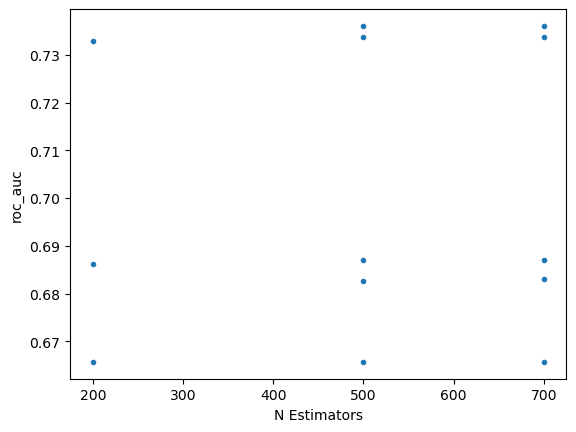

In [19]:
df_search_rfc = pd.DataFrame.from_dict(modelo_rfc_gs.cv_results_)
plt.xlabel('N Estimators')
plt.ylabel('roc_auc')
_ = plt.plot(df_search_rfc['param_n_estimators'], df_search_rfc['mean_test_score'], '.')

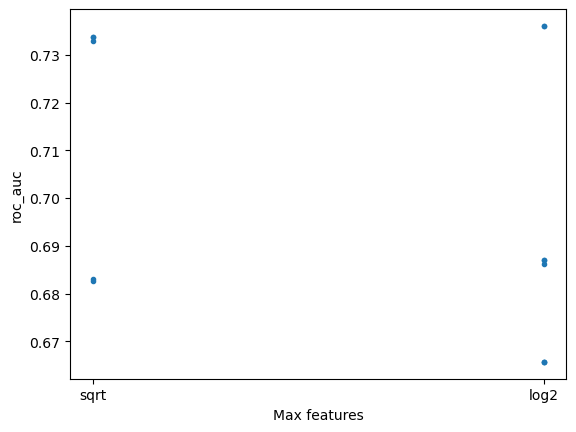

In [20]:
df_search_rfc = pd.DataFrame.from_dict(modelo_rfc_gs.cv_results_)
plt.xlabel('Max features')
plt.ylabel('roc_auc')
_ = plt.plot(df_search_rfc['param_max_features'], df_search_rfc['mean_test_score'], '.')

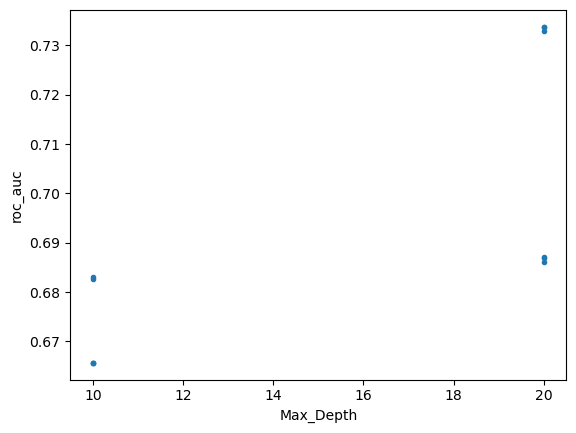

In [21]:
df_search_rfc = pd.DataFrame.from_dict(modelo_rfc_gs.cv_results_)
plt.xlabel('Max_Depth')
plt.ylabel('roc_auc')
_ = plt.plot(df_search_rfc['param_max_depth'], df_search_rfc['mean_test_score'], '.')

In [22]:
rfc = RandomForestClassifier(n_jobs = -1, max_features = modelo_rfc_gs.best_params_['max_features'],
                             n_estimators = modelo_rfc_gs.best_params_['n_estimators'],
                             max_depth = modelo_rfc_gs.best_params_['max_depth'], oob_score = True)

In [23]:
#Entrenamiento del modelo
rfc.fit(X_train_normalizado, Y_train)

RandomForestClassifier(max_features='log2', n_estimators=700, n_jobs=-1,
                       oob_score=True)

In [24]:
#Pruebas del modelo
y_pred_rfc = rfc.predict(X_test_normalizado)
y_pred_rfc_prob = rfc.predict_proba(X_test_normalizado)
y_test_pred_prob_pos_rfc = y_pred_rfc[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg_rfc = y_pred_rfc[np.where(Y_test == 0)[0]]

In [25]:
#Resultados 1
conf_matrix = confusion_matrix(Y_test, y_pred_rfc)
print("Matriz de Confusión:")
print(conf_matrix)

Matriz de Confusión:
[[ 6248  5535]
 [ 3664 19791]]


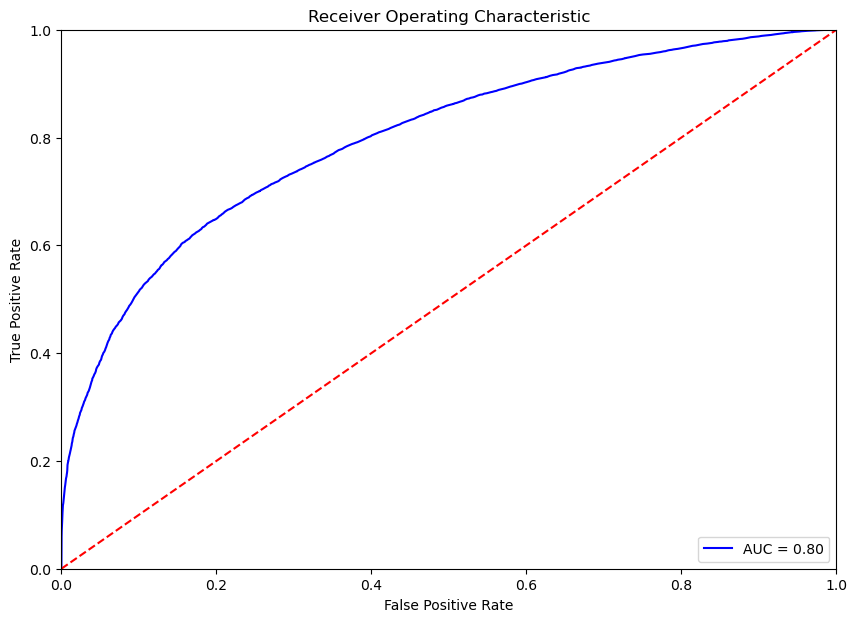

In [26]:
#Resultados 2
preds = y_pred_rfc_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
#Resultados 3
target_names = ['cierre', 'continuación']
reporte = classification_report(Y_test, y_pred_rfc, target_names = target_names)

print(reporte)

              precision    recall  f1-score   support

      cierre       0.63      0.53      0.58     11783
continuación       0.78      0.84      0.81     23455

    accuracy                           0.74     35238
   macro avg       0.71      0.69      0.69     35238
weighted avg       0.73      0.74      0.73     35238



El modelo tiene un buen desempeño general con un AUC ROC de 0.8, destacándose en la identificación de casos de continuación de negocios con alta precisión (0.78) y sensibilidad (0.8). Sin embargo, su precisión (0.63) y sensibilidad (0.53) para los casos de cierre son moderadas, lo que indica la presencia de falsos positivos y negativos. El F1-Score es bueno para la continuación (0.81) pero moderado para el cierre (0.58). La exactitud general del modelo es de 0.74, aunque esta métrica puede estar influenciada por el desbalance de clases.